# Classify Building Conditions in Zanzibar from Drone Imagery

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *

In [4]:
from fastai.utils import *
show_install()



```text
=== Software === 
python version  : 3.6.6
fastai version  : 1.0.33
torch version   : 1.0.0.dev20181114
nvidia driver   : 410.48
torch cuda ver  : 9.2.148
torch cuda is   : available
torch cudnn ver : 7104
torch cudnn is  : enabled

=== Hardware === 
nvidia gpus     : 1
torch available : 1
  - gpu0        : 16278MB | Quadro P5000

=== Environment === 
platform        : Linux-4.4.0-130-generic-x86_64-with-debian-stretch-sid
distro          : #156-Ubuntu SMP Thu Jun 14 08:53:28 UTC 2018
conda env       : Unknown
python          : /opt/conda/envs/fastai/bin/python
sys.path        : 
/opt/conda/envs/fastai/lib/python36.zip
/opt/conda/envs/fastai/lib/python3.6
/opt/conda/envs/fastai/lib/python3.6/lib-dynload
/opt/conda/envs/fastai/lib/python3.6/site-packages
/opt/conda/envs/fastai/lib/python3.6/site-packages/IPython/extensions
/root/.ipython
```

Please make sure to include opening/closing ``` when you paste into forums/github to make the reports appear formatted as code sections.


## Prepare Data

In [5]:
path = Path('/storage/classify-data')

In [6]:
path_img = path/'images'

In [7]:
fnames = get_image_files(path_img)
print(len(fnames))
fnames[:5]

20176


[PosixPath('/storage/classify-data/images/grid043_04750_Empty.jpg'),
 PosixPath('/storage/classify-data/images/grid058_05520_Empty.jpg'),
 PosixPath('/storage/classify-data/images/grid029_00149_Complete.jpg'),
 PosixPath('/storage/classify-data/images/grid042_02150_Empty.jpg'),
 PosixPath('/storage/classify-data/images/grid035_00463_Foundation.jpg')]

In [8]:
# filter out empty jpg files by size>0 and sort
fnames = [fname.name for fname in sorted(fnames) if os.path.getsize(fname)>0]
print(len(fnames))
fnames[:5]

20176


['grid001_00001_Complete.jpg',
 'grid001_00002_Complete.jpg',
 'grid001_00003_Complete.jpg',
 'grid001_00004_Complete.jpg',
 'grid001_00005_Complete.jpg']

In [9]:
df = pd.DataFrame(fnames,columns=['fnames'])
df.head()

fnames
0  grid001_00001_Complete.jpg
1  grid001_00002_Complete.jpg
2  grid001_00003_Complete.jpg
3  grid001_00004_Complete.jpg
4  grid001_00005_Complete.jpg

In [10]:
# hand-picked val grids
holdout_grids = ['grid028_','grid029_','grid042_','grid058_']
valid_idx = [i for i,o in df.iterrows() if any(c in str(o.fnames) for c in holdout_grids)]

In [11]:
df.iloc[valid_idx].head()

fnames
7432     grid028_00000_Empty.jpg
7433  grid028_00001_Complete.jpg
7434  grid028_00002_Complete.jpg
7435  grid028_00003_Complete.jpg
7436  grid028_00004_Complete.jpg

In [12]:
# pulled out of fastai/data.py
pat = r'([^_]+).jpg$'
pat = re.compile(pat)
def get_label(fn): return pat.search(str(fn)).group(1)

In [13]:
src = (ImageItemList.from_df(df, folder='images', path=path)
        .split_by_idx(valid_idx)
        .label_from_func(get_label, classes=['Complete', 'Incomplete', 'Foundation', 'Empty']))

In [55]:
bs = 32
sz = 512
tfms = get_transforms(flip_vert=True, max_rotate=0.2, max_warp=0., max_zoom=1.1, max_lighting=0.4)
data = (src.transform(tfms, size=512, resize_method=ResizeMethod.SQUISH, padding_mode='zeros')
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [56]:
data

ImageDataBunch;

Train: LabelList
y: CategoryList (14833 items)
[Category Complete, Category Complete, Category Complete, Category Complete, Category Complete]...
Path: /storage/classify-data
x: ImageItemList (14833 items)
[Image (3, 428, 920), Image (3, 184, 187), Image (3, 197, 196), Image (3, 157, 157), Image (3, 185, 188)]...
Path: /storage/classify-data;

Valid: LabelList
y: CategoryList (5343 items)
[Category Empty, Category Complete, Category Complete, Category Complete, Category Complete]...
Path: /storage/classify-data
x: ImageItemList (5343 items)
[Image (3, 243, 179), Image (3, 298, 234), Image (3, 186, 221), Image (3, 300, 181), Image (3, 176, 184)]...
Path: /storage/classify-data;

Test: None

In [57]:
data.train_ds.classes

['Complete', 'Incomplete', 'Foundation', 'Empty']

Empty /storage/classify-data/images/grid028_00000_Empty.jpg


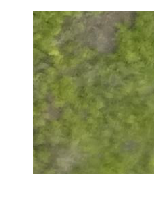

Complete /storage/classify-data/images/grid028_00001_Complete.jpg


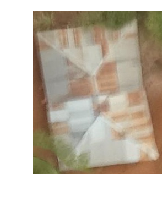

Complete /storage/classify-data/images/grid028_00002_Complete.jpg


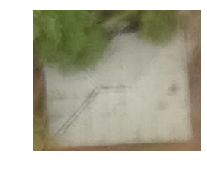

Complete /storage/classify-data/images/grid028_00003_Complete.jpg


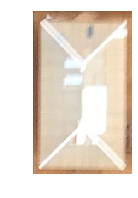

Complete /storage/classify-data/images/grid028_00004_Complete.jpg


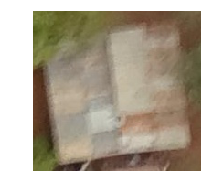

In [58]:
for i in range(5):
    print(data.valid_ds.classes[data.valid_ds.y[i].data], data.valid_ds.items[i]); 
    data.valid_ds.x[i].show()
    plt.show()

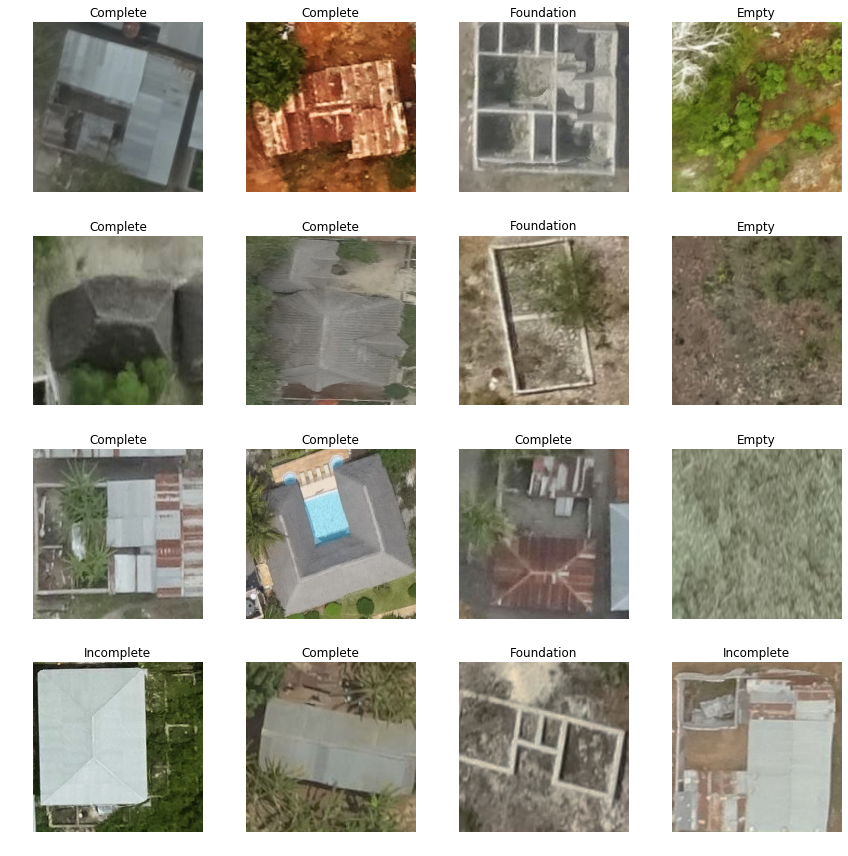

In [59]:
data.show_batch(rows=4, figsize=(12,12))

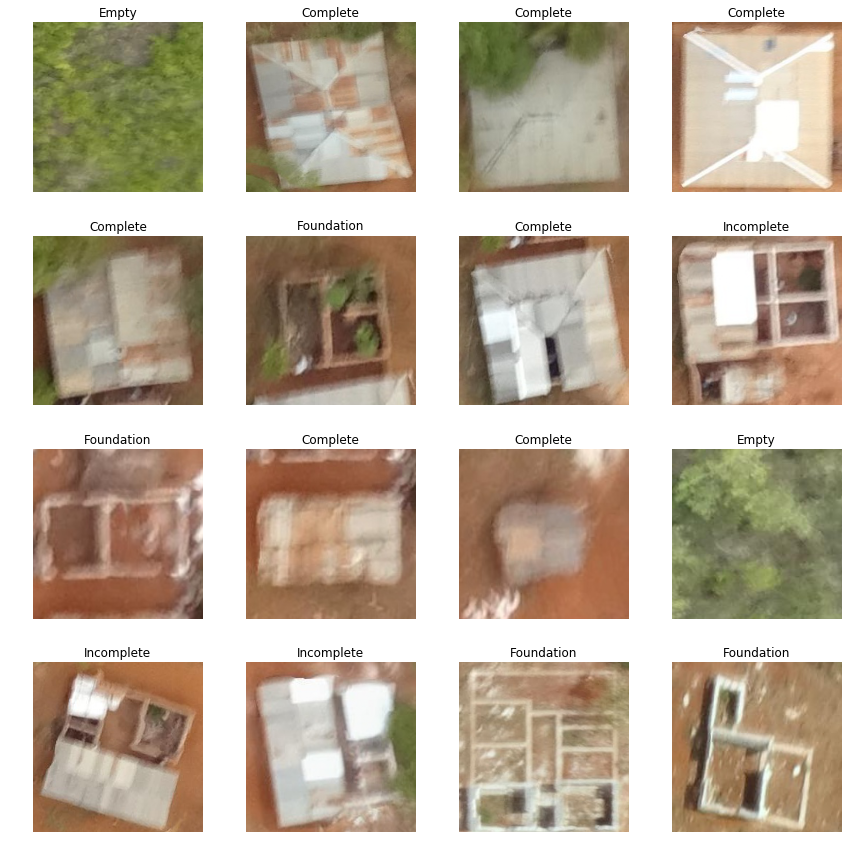

In [60]:
data.show_batch(rows=4, figsize=(12,12), ds_type=DatasetType.Valid)

In [61]:
data.loss_func

In [63]:
learn = create_cnn(data, models.resnet50, metrics=error_rate)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


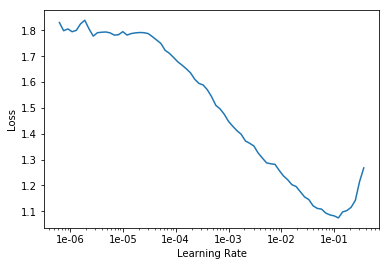

In [64]:
learn.lr_find()
learn.recorder.plot()

In [65]:
lr = 1e-2

In [67]:
from fastai.callbacks import *

# small change to SaveModelCallback() to add printouts
@dataclass
class SaveModelCallbackVerbose(TrackerCallback):
    "A `TrackerCallback` that saves the model when monitored quantity is best."
    every:str='improvement'
    name:str='bestmodel'
    def __post_init__(self):
        if self.every not in ['improvement', 'epoch']:
            warn(f'SaveModel every {self.every} is invalid, falling back to "improvement".')
            self.every = 'improvement'
        super().__post_init__()

    def on_epoch_end(self, epoch, **kwargs:Any)->None:
        if self.every=="epoch": self.learn.save(f'{self.name}_{epoch}')
        else: #every="improvement"
            current = self.get_monitor_value()
            if current is not None and self.operator(current, self.best):
                self.best = current
                self.learn.save(f'{self.name}')
                print(f'saved model at epoch {epoch} with {self.monitor} value: {current}')

    def on_train_end(self, **kwargs):
        if self.every=="improvement": self.learn.load(f'{self.name}')

In [68]:
learn.fit_one_cycle(10, max_lr=lr, 
                    callbacks=[
                        SaveModelCallbackVerbose(learn,
                                                 monitor='error_rate',
                                                 mode='min',
                                                 name='20181206-rn50class-stage1-best')
                    ]
                   )

saved model at epoch 1 with error_rate value: 0.08815272152423859
saved model at epoch 5 with error_rate value: 0.07785888016223907
saved model at epoch 6 with error_rate value: 0.07336702197790146
saved model at epoch 7 with error_rate value: 0.0656934306025505
saved model at epoch 8 with error_rate value: 0.06400898098945618
saved model at epoch 9 with error_rate value: 0.06157589331269264
saved model at epoch 10 with error_rate value: 0.06120157241821289


In [69]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


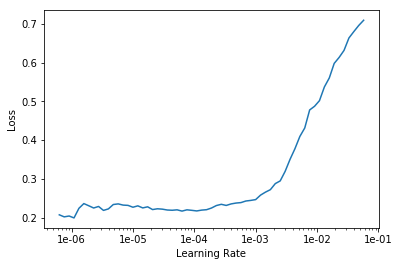

In [70]:
learn.lr_find()
learn.recorder.plot()

In [71]:
learn.fit_one_cycle(10, max_lr=slice(3e-5, lr/5), 
                    callbacks=[
                        SaveModelCallbackVerbose(learn,
                                                 monitor='error_rate',
                                                 mode='min',
                                                 name='20181206-rn50class-stage2-best')
                    ]
                   )

saved model at epoch 1 with error_rate value: 0.06924948841333389
saved model at epoch 4 with error_rate value: 0.06812652200460434
saved model at epoch 5 with error_rate value: 0.064944788813591
saved model at epoch 7 with error_rate value: 0.06026576831936836
saved model at epoch 10 with error_rate value: 0.05989144742488861


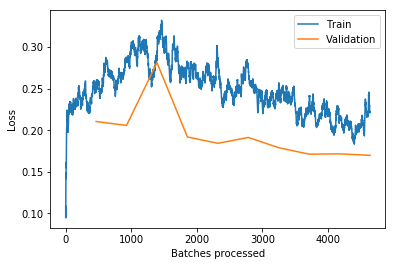

In [72]:
learn.recorder.plot_losses()

## Look at Results

In [74]:
interp = ClassificationInterpretation.from_learner(learn)

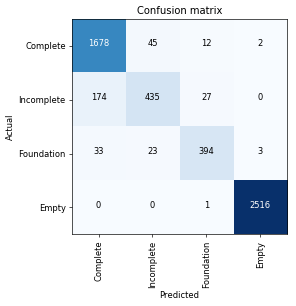

In [76]:
interp.plot_confusion_matrix(figsize=(5,5), dpi=60)

In [77]:
interp.most_confused(min_val=2)

[('Incomplete', 'Complete', 174),
 ('Complete', 'Incomplete', 45),
 ('Foundation', 'Complete', 33),
 ('Incomplete', 'Foundation', 27),
 ('Foundation', 'Incomplete', 23),
 ('Complete', 'Foundation', 12),
 ('Foundation', 'Empty', 3)]

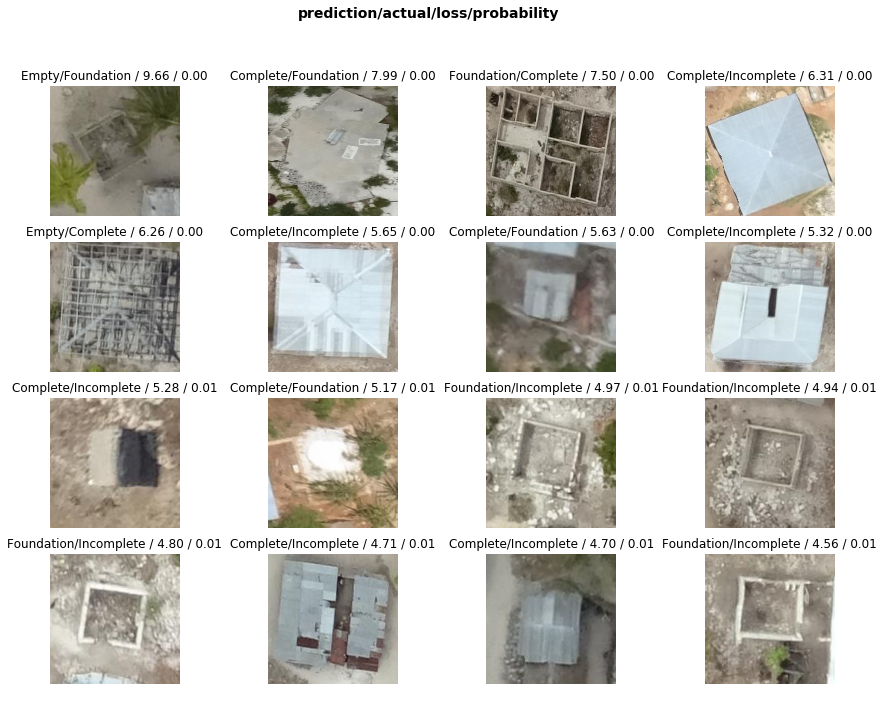

In [79]:
interp.plot_top_losses(16, figsize=(15,11))

## t-SNE Visualization (thanks to & adapted from @KarlH)

https://forums.fast.ai/t/share-your-work-here/27676/53

https://github.com/kheyer/ML-DL-Projects/blob/master/Pets%20TSNE/pets_tsne.ipynb

In [80]:
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn import manifold, datasets
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import confusion_matrix
from scipy.spatial.distance import squareform
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.ticker import NullFormatter
import PIL

In [81]:
preds = interp.probs
y = interp.y_true
losses = interp.losses

In [82]:
probs_trans = manifold.TSNE(n_components=2, perplexity=15).fit_transform(preds)

In [83]:
prob_df = pd.DataFrame(np.concatenate((probs_trans, y[:,None]), axis=1), columns=['x','y','labels'])
prob_df.head()

x          y  labels
0  56.746861 -47.716217     3.0
1 -48.950485  -3.635262     0.0
2  -5.009671   3.444134     0.0
3   3.583071  -5.047320     0.0
4 -21.317375 -26.444191     0.0

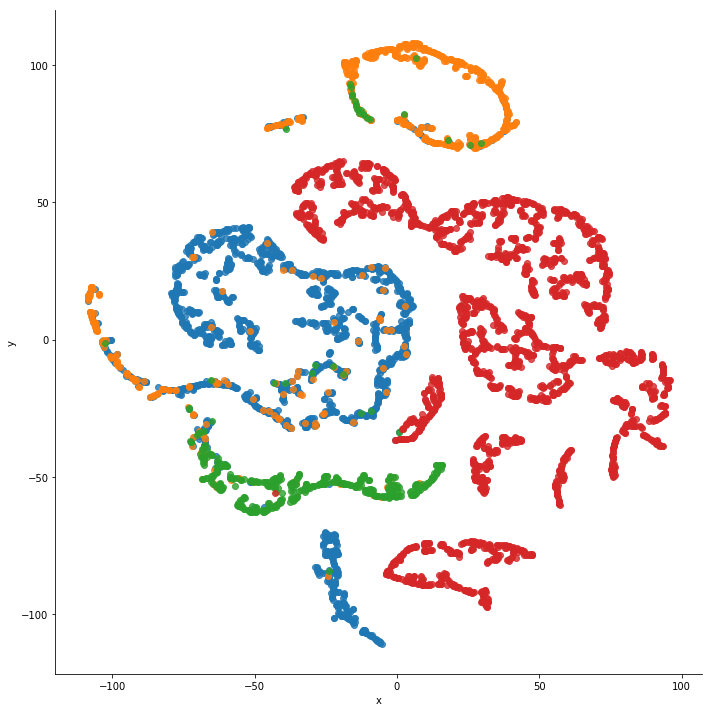

In [84]:
g = sns.lmplot('x', 'y', data=prob_df, hue='labels', fit_reg=False, legend=False, height=10)

In [85]:
prob_df['fname'] = data.valid_ds.items
prob_df['loss'] = losses
prob_df.head()

x          y  labels  \
0  56.746861 -47.716217     3.0   
1 -48.950485  -3.635262     0.0   
2  -5.009671   3.444134     0.0   
3   3.583071  -5.047320     0.0   
4 -21.317375 -26.444191     0.0   

                                               fname      loss  
0  /storage/classify-data/images/grid028_00000_Em... -0.000000  
1  /storage/classify-data/images/grid028_00001_Co...  0.003945  
2  /storage/classify-data/images/grid028_00002_Co...  0.046917  
3  /storage/classify-data/images/grid028_00003_Co...  0.048156  
4  /storage/classify-data/images/grid028_00004_Co...  0.080974

In [86]:
# modified to optionally filter by idxs

def visualize_scatter_with_images(scaled_data, df, idxs, figsize=(64,64), image_zoom=1, suffix=1):
    scaled_data = scaled_data[idxs]
    df = df.iloc[idxs]

    fig, ax = plt.subplots(figsize=figsize)
    artists = []
    xx = (scaled_data[:,0])
    yy = (scaled_data[:,1])
    
    for (i,x,y) in zip(idxs,xx,yy):
        im = PIL.Image.open(df['fname'][i])
        im.thumbnail((64,64))
        img = OffsetImage(im, zoom=image_zoom, cmap='gray')
        ab = AnnotationBbox(img, (x, y), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([xx,yy]))
    ax.autoscale()
    
#     fig.savefig(f'TSNE_{suffix}.jpg', bbox_inches = 'tight')
    return fig, ax

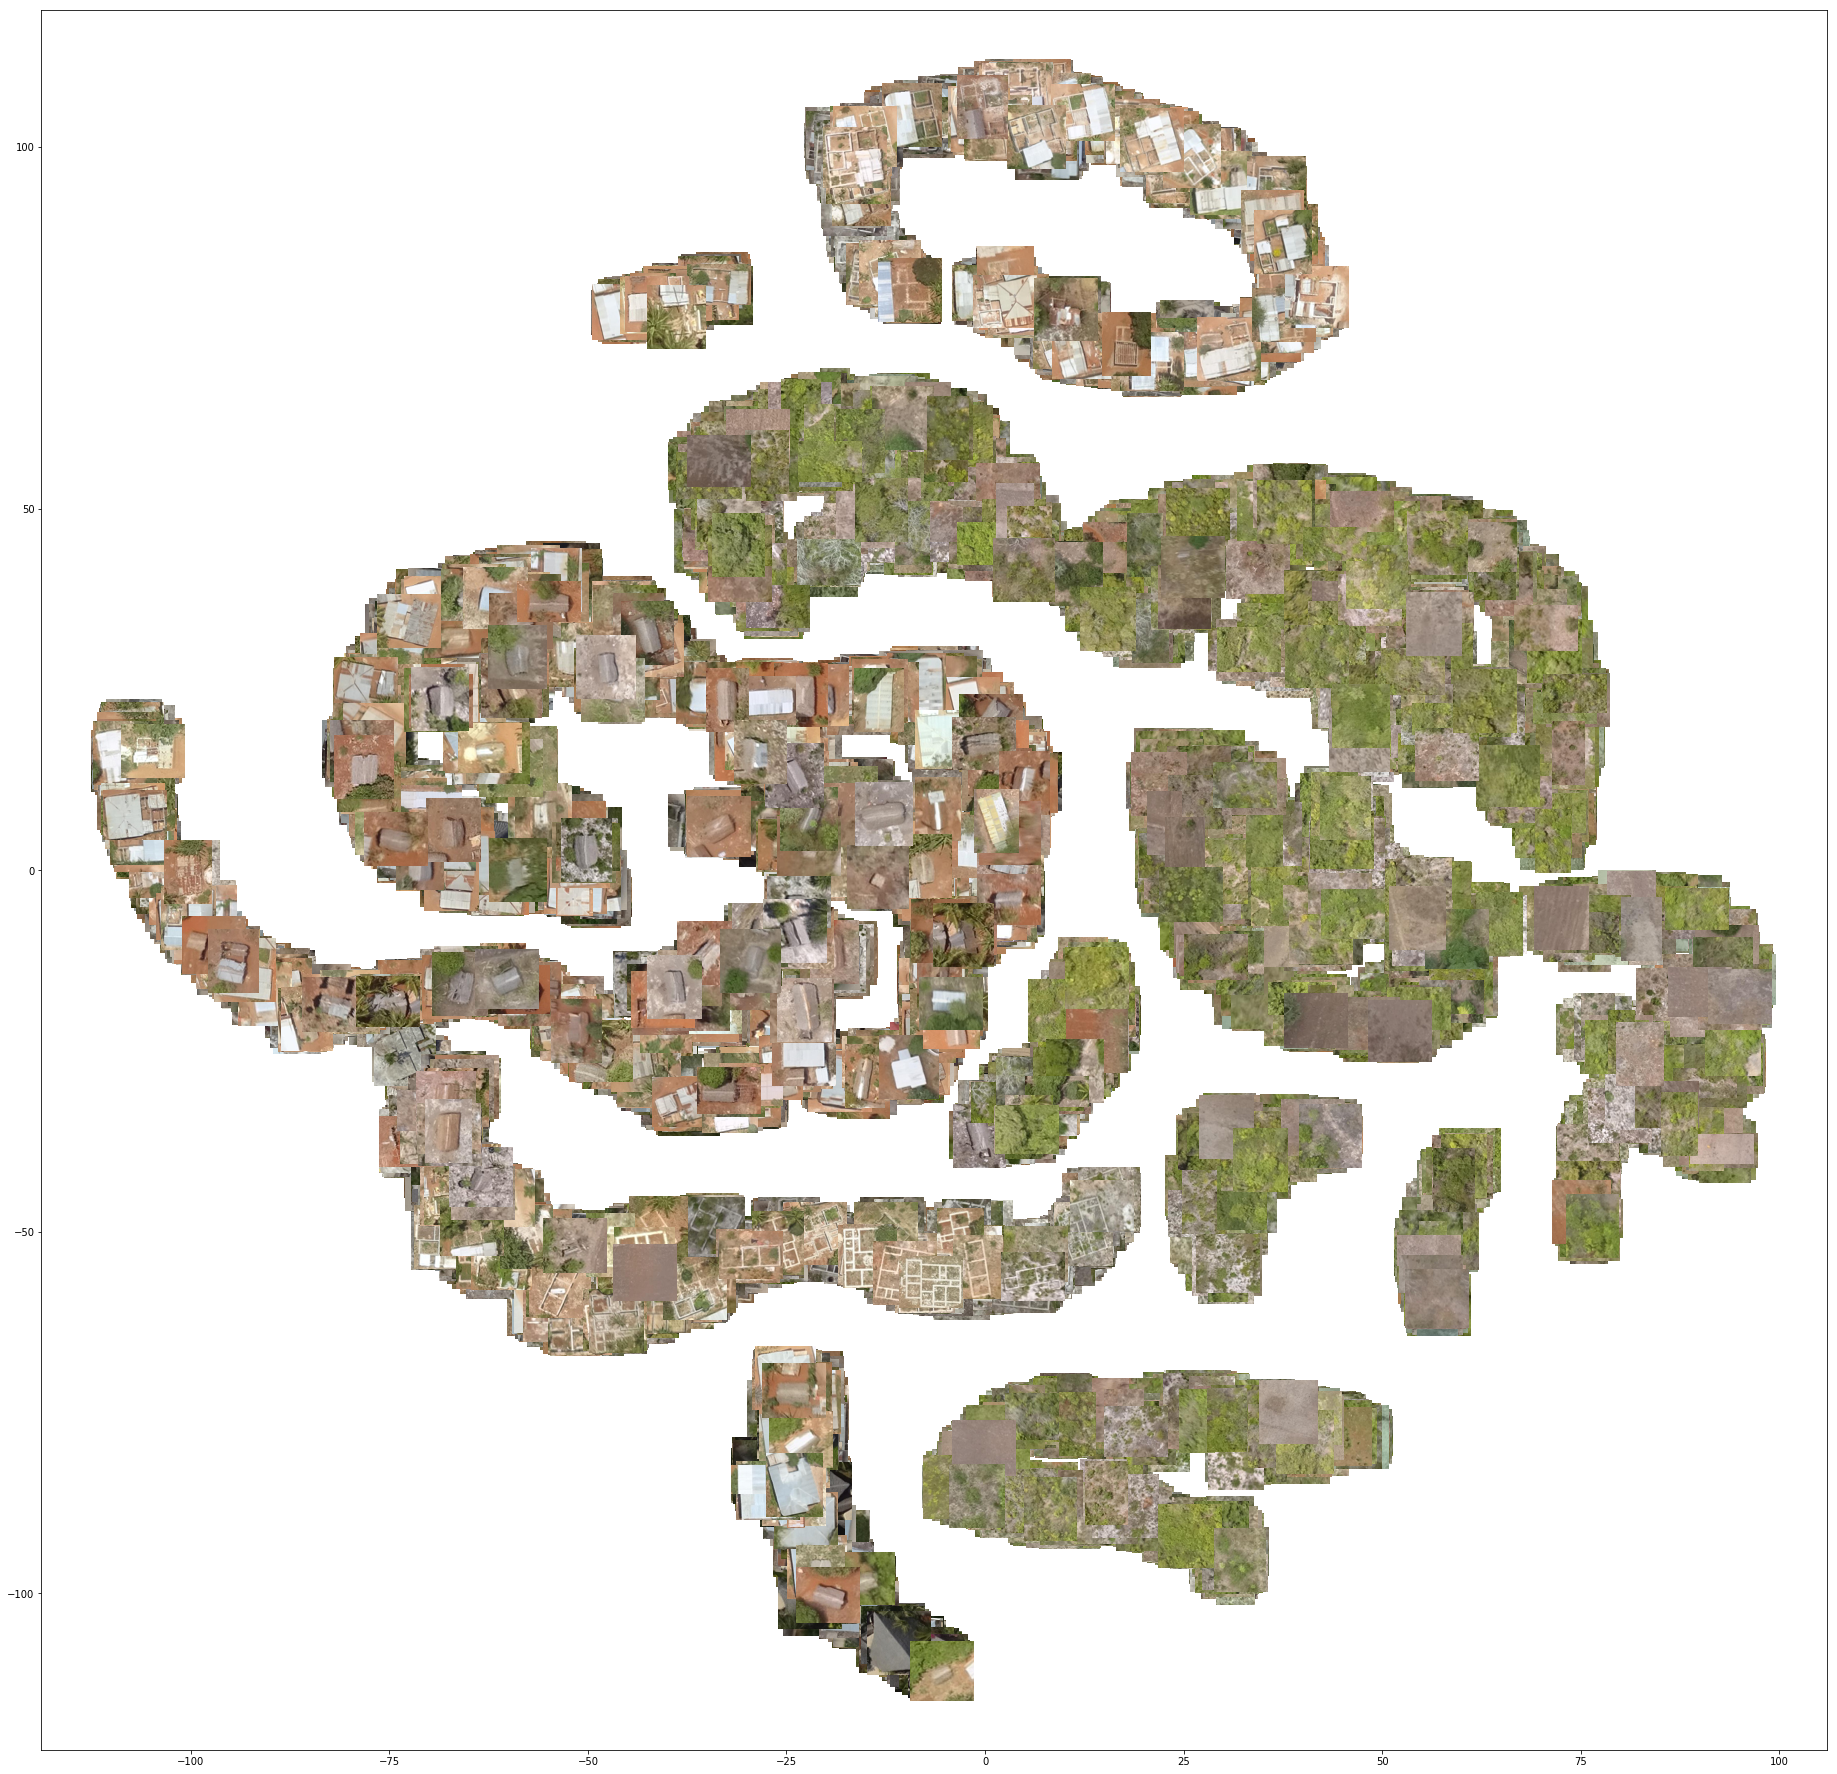

In [87]:
fig, ax = visualize_scatter_with_images(probs_trans, prob_df, range(len(prob_df)), figsize=(32,32), image_zoom=1, suffix='probabilities')
plt.show()

In [88]:
top_losses = prob_df['loss'].sort_values(ascending=False)[:20].index.values

In [89]:
prob_df.iloc[top_losses]

x          y  labels  \
1676   9.071122 -30.559656     2.0   
2390 -23.901659 -84.158226     2.0   
2236 -23.951727 -52.477448     0.0   
3955 -24.108377 -86.259254     1.0   
2984   0.596981 -33.512062     0.0   
1449 -51.541935   3.057128     1.0   
2847  -9.209568 -26.133133     2.0   
1460 -65.345856   4.596048     1.0   
1477 -61.389629  17.511150     1.0   
3560 -12.731878 -26.593086     2.0   
2052   7.851956 -52.302036     1.0   
2059  11.943326 -50.991638     1.0   
1486  -1.297820 -50.215778     1.0   
2546 -71.905006  29.902550     1.0   
2484 -71.327370  29.958330     1.0   
1494  -2.534295 -50.299793     1.0   
2032  29.490635  71.660698     2.0   
1917 -64.892960  39.141045     1.0   
4086 -65.361137 -14.892749     2.0   
1542 -46.737644 -61.083656     0.0   

                                                  fname      loss  
1676  /storage/classify-data/images/grid029_00218_Fo...  9.658810  
2390  /storage/classify-data/images/grid029_00880_Fo...  7.988194  
2236  /storage/classify-data/images/grid029_00735_Co...  7.502900  
3955  /storage/classify-data/images/grid042_00397_In...  6.312711  
2984  /storage/classify-data/images/grid029_01434_Co...  6.264024  
1449  /storage/classify-data/images/grid029_00008_In...  5.652417  
2847  /storage/classify-data/images/grid029_01307_Fo...  5.629231  
1460  /storage/classify-data/images/grid029_00018_In...  5.316871  
1477  /storage/classify-data/images/grid029_00033_In...  5.279524  
3560  /storage/classify-data/images/grid042_00037_Fo...  5.165102  
2052  /storage/classify-data/images/grid029_00566_In...  4.968777  
2059  /storage/classify-data/images/grid029_00572_In...  4.938722  
1486  /storage/classify-data/images/grid029_00041_In...  4.802966  
2546  /storage/classify-data/images/grid029_01027_In...  4.712808  
2484  /storage/classify-data/images/grid029_00969_In...  4.699991  
1494  /storage/classify-data/images/grid029_00049_In...  4.557220  
2032  /storage/classify-data/images/grid029_00547_Fo...  4.507183  
1917  /storage/classify-data/images/grid029_00440_In...  4.495970  
4086  /storage/classify-data/images/grid042_00516_Fo...  4.469344  
1542  /storage/classify-data/images/grid029_00094_Co...  4.340938

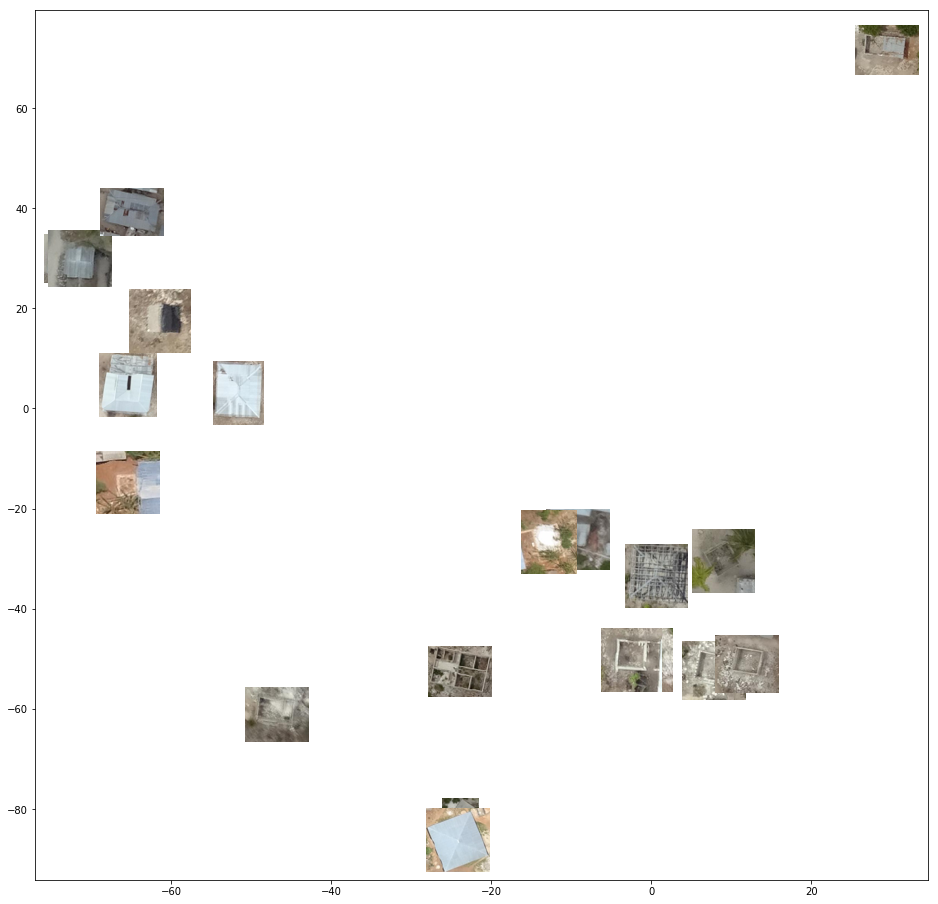

In [90]:
# show only images with top 20 losses
fig, ax = visualize_scatter_with_images(probs_trans, prob_df, top_losses, figsize=(16,16),image_zoom=1, suffix='probabilities')
plt.show()

## Grad-CAM based on lesson6-pets-more

In [91]:
m = learn.model.eval()

Category Incomplete

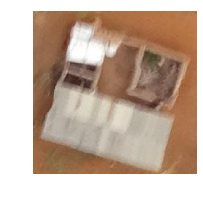

In [92]:
idx = 12
x,y = data.valid_ds[idx]
x.show()
data.valid_ds.y[idx]

In [93]:
xb, yb = data.one_item(x) # make batch with one item
xb_im = Image(data.denorm(xb)[0]) # denorm item into viewable image
xb = xb.cuda() # load on gpu

(None, torch.Size([1, 3, 512, 512]), torch.Size([1]))

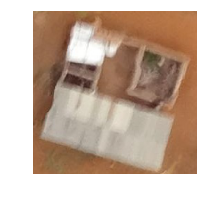

In [94]:
xb_im.show(), xb.shape, yb.shape

In [95]:
y, yb

(Category Incomplete, tensor([0], device='cuda:0'))

In [96]:
from fastai.callbacks.hooks import *
import pdb

In [115]:
def hooked_backward(cat=y):
#     pdb.set_trace()
    with hook_output(m[0]) as hook_a: # set activation hook
        with hook_output(m[0], grad=True) as hook_g: # set gradient hook
            preds = m(xb) # forward pass
            preds[0,int(cat)].backward() # backward pass
    return hook_a, hook_g

In [116]:
hook_a, hook_g = hooked_backward()

In [117]:
acts = hook_a.stored[0].cpu()

In [118]:
acts.shape

torch.Size([2048, 16, 16])

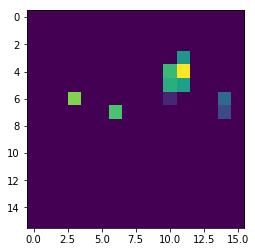

In [119]:
plt.imshow(acts[0])

In [120]:
avg_acts = acts.mean(0) # get the "pixel"-wise mean of activations (avg across 2018 channels)
avg_acts.shape

torch.Size([16, 16])

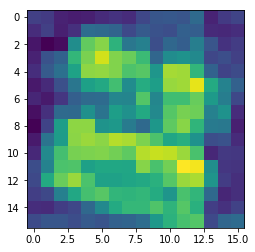

In [121]:
plt.imshow(avg_acts)

In [122]:
grad = hook_g.stored[0][0].cpu()

In [123]:
grad.shape

torch.Size([2048, 16, 16])

In [124]:
grad_chan = grad.mean(1).mean(1) # get the avg of grads for each channel
grad.shape, grad_chan.shape

(torch.Size([2048, 16, 16]), torch.Size([2048]))

In [125]:
grad_chan[...,None,None].shape # make 2 more axes to be same shape as acts

torch.Size([2048, 1, 1])

In [126]:
(acts*grad_chan[...,None,None]).mean(0).shape

torch.Size([16, 16])

In [127]:
mult = (acts*grad_chan[...,None,None]).mean(0)

In [129]:
def show_heatmap(hm,interpol='bilinear',cmap='magma'):
    _, ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.6, extent=(0,512,512,0), interpolation=interpol,cmap=cmap)

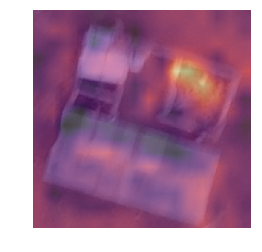

In [130]:
show_heatmap(mult)

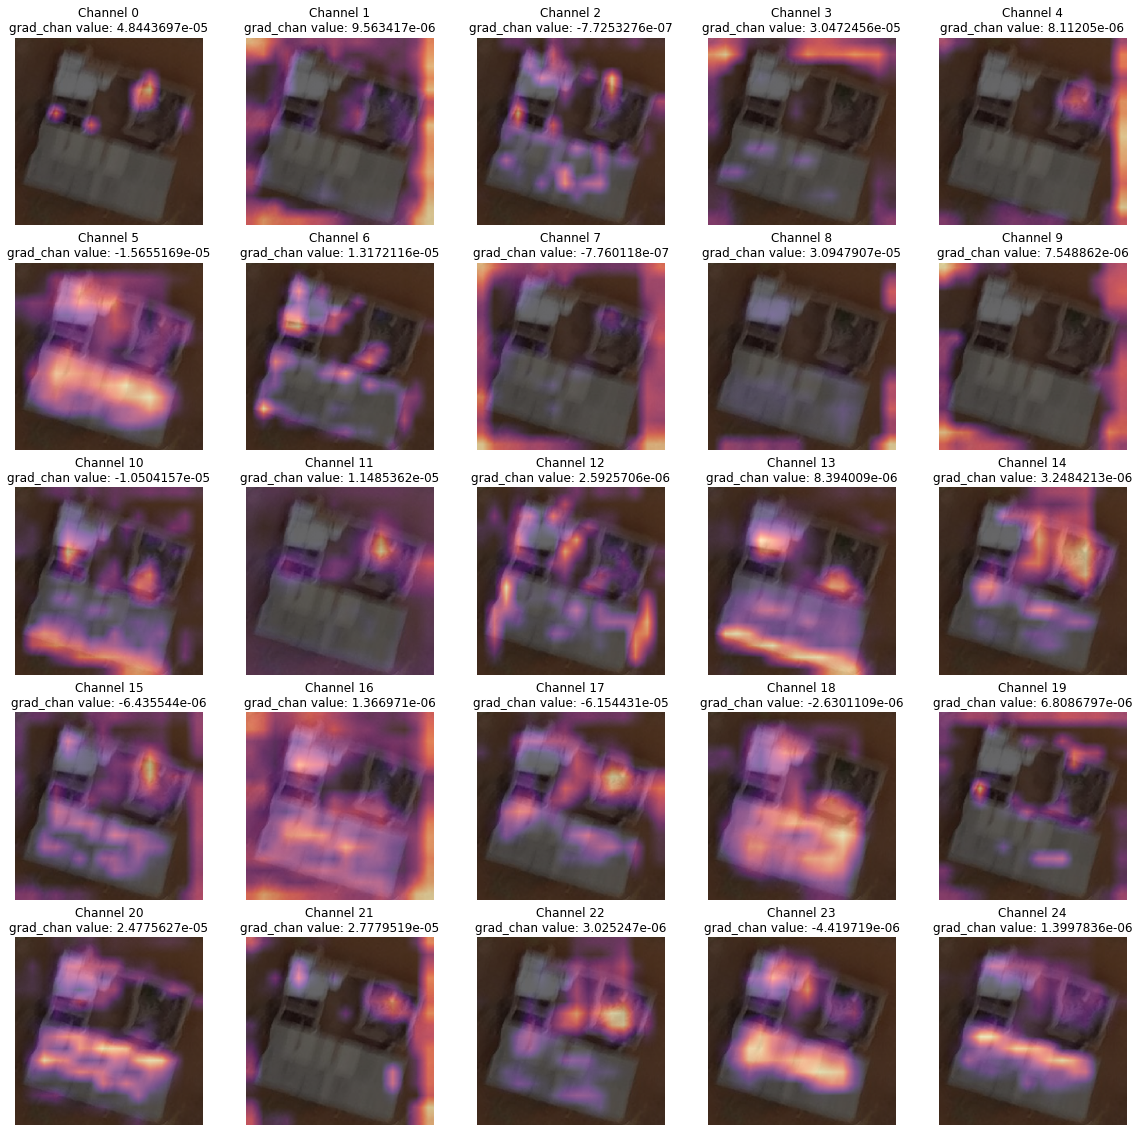

In [134]:
fig, axes = plt.subplots(5,5, figsize=(20,20))
for j, ax in enumerate(axes.flat):
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    xb_im.show(ax=ax)
    ax.set_title('Channel '+str(j)+ '\n'+'grad_chan value: '+str(grad_chan.numpy()[j]))
    ax.imshow(acts[j], alpha=0.6, extent=(0,512,512,0), interpolation='bilinear',cmap='magma')
#     ax.imshow([importance_idxs[j]]), alpha=0.6)
plt.show()

In [135]:
# thanks @henripal, from https://github.com/henripal/maps/blob/master/nbs/big_resnet50-interpret-gradcam-dogs.ipynb
import scipy.ndimage

def upsample(heatmap, zoom=32):
    upsampled = scipy.ndimage.zoom(heatmap, zoom)
    upsampled = (upsampled - np.min(upsampled))/((np.max(upsampled) - np.min(upsampled))+1e-16)
    return upsampled

In [136]:
grad_df = pd.DataFrame(grad_chan.numpy(), columns=['grad_chan'])
grad_df.head()

grad_chan
0  4.844370e-05
1  9.563417e-06
2 -7.725328e-07
3  3.047246e-05
4  8.112050e-06

In [137]:
importance_idxs = grad_df.sort_values(by='grad_chan',ascending=False).index.values
importance_idxs

array([ 101,  220, 1270,  631, ...,   74,  844, 1954,  660])

In [138]:
grad_df.iloc[importance_idxs].head()

grad_chan
101    0.005839
220    0.003543
1270   0.002052
631    0.001911
1813   0.001636

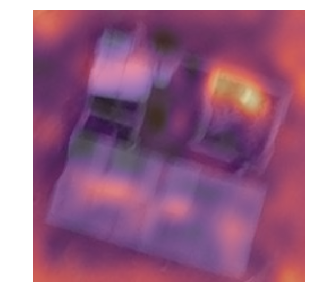

In [143]:
# heatmap with most important 100 activations (ranked by grad_chan)
fm_up = [upsample(fm) for fm in acts[importance_idxs[:100]]]
xb_im.show(figsize=(5,5))
plt.imshow(np.mean(fm_up, axis=0),alpha=0.6, cmap='magma')

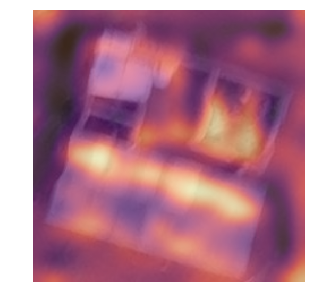

In [144]:
# heatmap with least important 100 activations (ranked by grad_chan)
fm_up = [upsample(fm) for fm in acts[importance_idxs[-100:]]]
xb_im.show(figsize=(5,5))
plt.imshow(np.mean(fm_up, axis=0),alpha=0.6, cmap='magma')

## Test time

In [145]:
data.export()

In [146]:
empty_data = ImageDataBunch.load_empty(path, tfms=tfms, size=512).normalize(imagenet_stats)
learn = create_cnn(empty_data, models.resnet50)

In [147]:
empty_data.classes

['Complete', 'Incomplete', 'Foundation', 'Empty']

In [148]:
learn.load('20181206-rn50class-stage2-best')
learn.model.eval()

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_s

In [149]:
grid_num = '119'
test_path = Path(f'/storage/znz-classify-001/demo_test/test_{grid_num}')
test_fns = [o for o in sorted(test_path.iterdir()) if '.jpg' in o.name]
print(len(test_fns))

13552


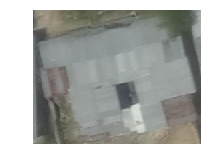

In [161]:
img = open_image(test_fns[100])
img.show()
plt.show()

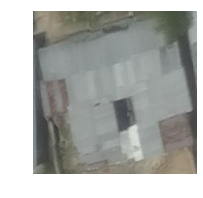

In [162]:
img = img.apply_tfms(tfms[1],resize_method=ResizeMethod.SQUISH, size=512, bs=1)
img.show()

In [165]:
learn.predict(img)

(Category Complete,
 tensor(0),
 tensor([9.6798e-01, 3.0493e-02, 1.4308e-03, 9.5591e-05]))

In [152]:
from tqdm import tqdm

In [154]:
preds = []
pred_classes = []
for fn in tqdm(test_fns[:100]):
    try: 
        img = open_image(fn)
        img = img.apply_tfms(tfms[1],resize_method=ResizeMethod.SQUISH, size=512, bs=1)
        pred_class,pred_idx,outputs = learn.predict(img)
        preds.append(list(to_np(outputs)))
        pred_classes.append(pred_class)
    except Exception as exc: 
        print(f'{exc}') 
        preds.append([-1,-1,-1,-1])
        pred_classes.append('error')

100%|██████████| 100/100 [00:04<00:00, 20.55it/s]


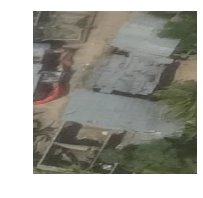

In [155]:
img.show()

In [156]:
np.round(preds,2)

array([[0.99, 0.01, 0.  , 0.  ],
       [0.99, 0.01, 0.  , 0.  ],
       [0.51, 0.49, 0.  , 0.  ],
       [0.17, 0.04, 0.79, 0.  ],
       ...,
       [1.  , 0.  , 0.  , 0.  ],
       [0.97, 0.01, 0.  , 0.02],
       [0.95, 0.04, 0.  , 0.  ],
       [0.33, 0.66, 0.01, 0.  ]], dtype=float32)

In [157]:
np.round(preds,2)

array([[0.99, 0.01, 0.  , 0.  ],
       [0.99, 0.01, 0.  , 0.  ],
       [0.51, 0.49, 0.  , 0.  ],
       [0.17, 0.04, 0.79, 0.  ],
       ...,
       [1.  , 0.  , 0.  , 0.  ],
       [0.97, 0.01, 0.  , 0.02],
       [0.95, 0.04, 0.  , 0.  ],
       [0.33, 0.66, 0.01, 0.  ]], dtype=float32)

In [158]:
df = pd.DataFrame(data=preds, columns=data.classes)
df['fname'] = [o.name for o in test_fns[:len(preds)]]
df['predicted_class'] = pred_classes

In [159]:
df.head()

Complete  Incomplete  Foundation     Empty               fname  \
0  0.985044    0.013088    0.001585  0.000283  119_00000_test.jpg   
1  0.986397    0.013174    0.000414  0.000015  119_00001_test.jpg   
2  0.506189    0.490988    0.002788  0.000035  119_00002_test.jpg   
3  0.166216    0.043905    0.789644  0.000234  119_00003_test.jpg   
4  0.953893    0.045666    0.000435  0.000005  119_00004_test.jpg   

  predicted_class  
0        Complete  
1        Complete  
2        Complete  
3      Foundation  
4        Complete

Complete 0.9850437641143799


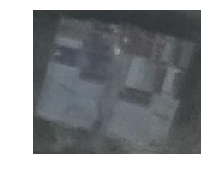

Complete 0.9863974452018738


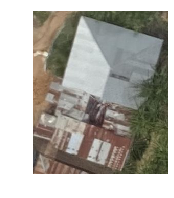

Complete 0.5061893463134766


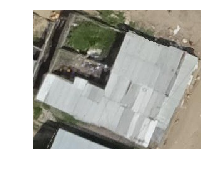

Foundation 0.789644181728363


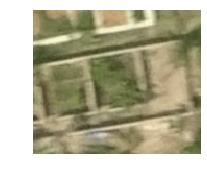

Complete 0.9538934826850891


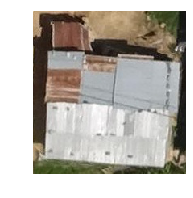

Foundation 0.9689040780067444


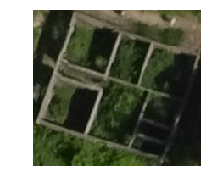

Complete 0.9510454535484314


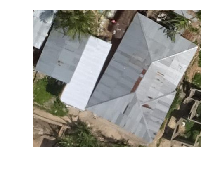

Incomplete 0.5464768409729004


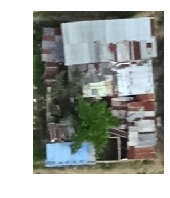

Complete 0.586933970451355


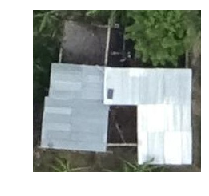

Complete 0.9919455647468567


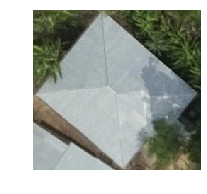

In [160]:
for i in range(10):
    img = open_image(test_path/df.iloc[i]['fname'])
    print(df.iloc[i]['predicted_class'], df.iloc[i][df.iloc[i]['predicted_class'].data])
    img.show()
    plt.show()

In [220]:
df.to_csv('preds.csv',index=False)